# Selection of genes with close neighbours in individual strains
For each strain and merged vector of measurments termed 'all' genes that have highest similarity to their closest 5 neighbours (actually 6 as one is itself) were selected. The gene sets obtained in each of these groups were compared with hierarchical clustering on Jaccard index transformed to distances. The jaccard index summarizes the degree of similarity between two sets. The data used was RPKUM mt removed polyA data.\
The data for each strain was obtained by merging replicates into a single strain feature vector, except where noted elsehow.

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from statistics import median, mean
from scipy.cluster.hierarchy import dendrogram
import pickle as pkl
import glob
import seaborn as sb
from sklearn.metrics.pairwise import cosine_similarity

from Orange.clustering.louvain import jaccard

import library_regulons
reload(library_regulons)
from library_regulons import *
import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from functionsDENet import loadPickle, savePickle
import deR.enrichment_library as enr
reload(enr)
import deR.enrichment_library as enr


In [2]:
dataPath = '/home/karin/Documents/timeTrajectories/data/RPKUM/combined/'
dataPathSaved = '/home/karin/Documents/timeTrajectories/data/regulons/'
pathSelGenes = dataPathSaved + 'selected_genes/'

In [3]:
genes_all = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
conditions_all = pd.read_csv(dataPath + 'conditions_mergedGenes.tsv', sep='\t', index_col=None)

In [4]:
SCALE = 'mean0std1'
LOG = True
NEIGHBOURS = 6
SPLITBY = 'Strain'

In [5]:
def calculate_similarities(genes,conditions,n_neighbours, scale,use_log,splitby):
    neighbour_calculator_all = NeighbourCalculator(genes=genes)
    neigh_all, sims_all = neighbour_calculator_all.neighbours(n_neighbours=n_neighbours, inverse=False, 
                                                              scale=scale, log=use_log,
                                                              return_neigh_dist=True)

    # On replicates
    # Split data by replicate, scaling and zero filtering is done in neighbours
    merged = ClusterAnalyser.merge_genes_conditions(genes=genes, conditions=conditions[['Measurment', splitby]],
                                                    matching='Measurment')
    splitted = ClusterAnalyser.split_data(data=merged, split_by=splitby)
    for rep, data in splitted.items():
        splitted[rep] = data.drop([SPLITBY, 'Measurment'], axis=1).T

    # Claulculate neighbours - sims_dict has similarity matrices from samples
    sims_dict = dict()
    for rep, data in splitted.items():
        print(rep)
        neighbour_calculator = NeighbourCalculator(genes=data)
        neigh, sims_dict[rep] = neighbour_calculator.neighbours(n_neighbours=n_neighbours, inverse=False, 
                                                                scale=scale,
                                                                log=use_log,
                                                                return_neigh_dist=True)
    sims_dict['all'] = sims_all
    return sims_dict

def retained_genes(sims_dict,nhubs,splitby='Strain'):
    retained_genes_dict = dict()
    for rep, sims in sims_dict.items():
        retained_genes_dict[rep] = NeighbourCalculator.find_hubs(similarities=sims_dict[rep], n_hubs=nhubs)

    replicates = list(retained_genes_dict.keys())
    # Calculates similarities between retained genes of different samples
    retained_genes_jaccard = pd.DataFrame()
    dist_arr = []
    for idx, rep1 in enumerate(replicates[:-1]):
        for rep2 in replicates[idx + 1:]:
            genes1 = set(retained_genes_dict[rep1])
            genes2 = set(retained_genes_dict[rep2])
            jaccard_index = jaccard(genes1, genes2)
            dist_arr.append(1 - jaccard_index)

    # Plot similarity
    plt.figure(figsize=(10,5))
    hc.dendrogram(hc.ward(dist_arr), labels=replicates, color_threshold=0)
    plt.title('Clustered ' + splitby + 's based on jaccard distance of selected genes')


### Data: Using all replicates

In [ ]:
#sims_dict5=calculate_similarities(genes=genes_all,conditions=conditions_all,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict5=loadPickle(pathSelGenes+'newGenes_noAvg_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

Based on 1000 genes with highest average similarity to closest neighbour

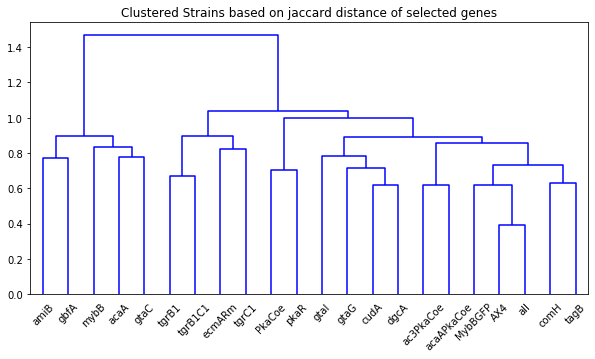

In [8]:
retained_genes(sims_dict5,nhubs=1000,splitby='Strain')

Based on 200 genes with highest average similarity to closest neighbour

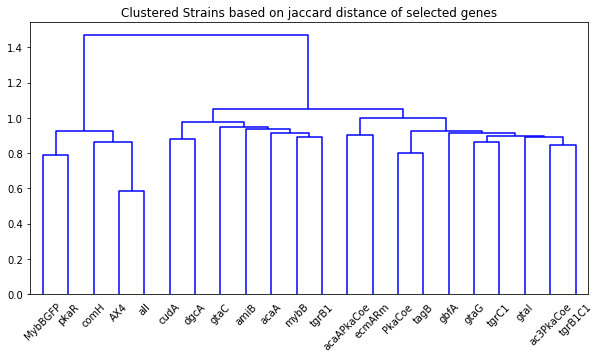

In [9]:
retained_genes(sims_dict5,nhubs=200,splitby='Strain')

The clustering shows clear bias of genes selected on 'all' towards AX4 and thus less developmentaly stunted strains.

Thus averaging and data removal was used below to try to mitigate the bias. It was hoped that this would reduce the bias of 'all' towards AX4 due to having less measurments/features in AX4.

### Data: Averaging AX4
AX4 replicates were replaced with 3 averaged AX4 datasets: PE,SE, and FD. 

In [11]:
# ********** Average AX4 samples form new data
# Split to AX4 and rest of data
genes_conditions = ClusterAnalyser.merge_genes_conditions(genes=genes_all, conditions=conditions_all, matching='Measurment')
conditions_AX4 = conditions_all.loc[conditions_all['Strain'] == 'AX4', :]
conditions_rest = conditions_all.loc[conditions_all['Strain'] != 'AX4', :]
# Select AX4/rest genes by conditions rows so that they are both ordered the same
genes_AX4 = genes_conditions.loc[conditions_AX4['Measurment'], :]
genes_rest = genes_conditions.loc[conditions_rest['Measurment'], :]

# This is dropped in AX4 while averaging
genes_rest = genes_rest.drop(['Time', 'Strain', 'Replicate', 'Measurment'], axis=1)

# Group and average AX4, add averaged to rest
groupped_AX4 = genes_AX4.set_index('Replicate').groupby(
    {'AX4_FD_r1': 'AX4_FD', 'AX4_FD_r2': 'AX4_FD', 'AX4_PE_r3': 'AX4_PE',
     'AX4_PE_r4': 'AX4_PE', 'AX4_SE_r5': 'AX4_SE', 'AX4_SE_r6': 'AX4_SE',
     'AX4_SE_r7': 'AX4_SE'})
for name, group in groupped_AX4:
    group = group.groupby('Time').mean()
    times = list(group.index)
    group.index = [str(name) + '_' + str(idx) for idx in times]
    conditions_rest = conditions_rest.append(
        pd.DataFrame({'Measurment': group.index, 'Strain': ['AX4'] * group.shape[0],
                      'Replicate': [name] * group.shape[0], 'Time': times}), ignore_index=True, sort=True)
    genes_rest = genes_rest.append(group, sort=True)

genes_rest = genes_rest.T
# Check that ordered the same
if not (genes_rest.columns.values == conditions_rest['Measurment'].values).all():
    print('Genes and conditions are not ordered the same')

genes_avg = genes_rest
conditions_avg = conditions_rest

In [ ]:
#sims_dict4=calculate_similarities(genes=genes_avg,conditions=conditions_avg,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict=loadPickle(pathSelGenes + 'newGenes_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

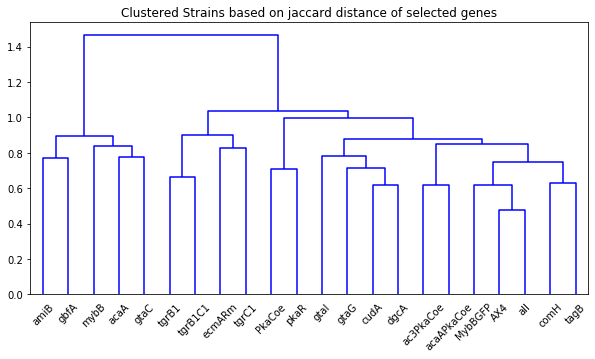

In [32]:
retained_genes(sims_dict,nhubs=1000,splitby='Strain')

### Data: no MybBGFP, AX4 only PE (2 replicates)
To further reduce the bias of 'all' towards AX4 the data of MybBGFB, which is similar to AX4, was removed and  only 2 AX4 replicates (PE) were used, further reducing number of AX4 measurments.

In [13]:
# Data without mybBGFP and only AX4_PE (non averaged)
conditions1 = conditions_all.loc[(conditions_all['Strain'] != 'MybBGFP') & (~conditions_all['Replicate'].str.contains('AX4_SE')) &
                            (~conditions_all['Replicate'].str.contains('AX4_FD')), :]
genes1 = genes_all.loc[:, conditions1['Measurment']]


In [29]:
#sims_dict1=calculate_similarities(genes=genes1,conditions=conditions1,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict1=loadPickle(pathSelGenes + 'newGenes_noMybBGFP-AX4onlyPE_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

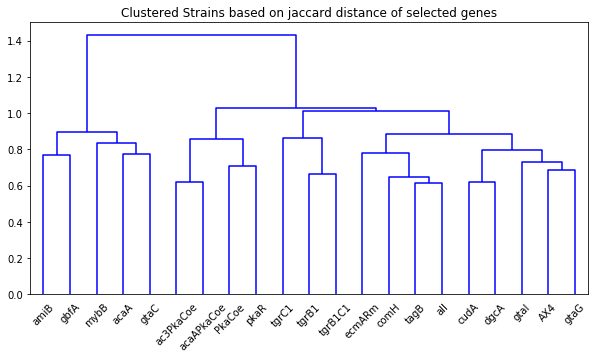

In [23]:
retained_genes(sims_dict1,nhubs=1000,splitby='Strain')

### Data: 7 measurements per replicate, no MybBGFP, AX4 only PE (2 replicates)
To further remove the bias that porobably arose due to  different number of measurments/features in individual strains only 7 measurments were used for each replicate (at time points present in most strains). Two replicates were used for each strain (for AX4 this was PE), except for gtaC wher all 20 measurments across four replicates were used. MybBGFP was not used. Even this strong correction did not completely remove the bias, possibly because there are less strains with severly stunted development, based on the dendrogram. 

In [24]:
conditions2 = conditions_all.loc[(conditions_all['Strain'] != 'MybBGFP') & (~conditions_all['Replicate'].str.contains('AX4_SE')) &
                            (~conditions_all['Replicate'].str.contains('AX4_FD')), :]
conditions_gtaC = conditions2.loc[conditions2['Strain'] == 'gtaC', :]
conditions2 = conditions2.loc[conditions2['Strain'] != 'gtaC', :]
conditions2 = conditions2.loc[conditions2['Time'].isin([0, 4, 8, 12, 16, 20, 24]), :]
conditions2 = conditions2.append(conditions_gtaC)
genes2 = genes_all.loc[:, conditions2['Measurment']]


In [28]:
#sims_dict2=calculate_similarities(genes=genes2,conditions=conditions2,n_neighbours=NEIGHBOURS, scale=SCALE,use_log=LOG,splitby=SPLITBY)
sims_dict2=loadPickle(pathSelGenes + 'newGenes_7points-noMybBGFP-AX4onlyPE_simsDict_scalemean0std1_logTrue_kN6_splitStrain.pkl')

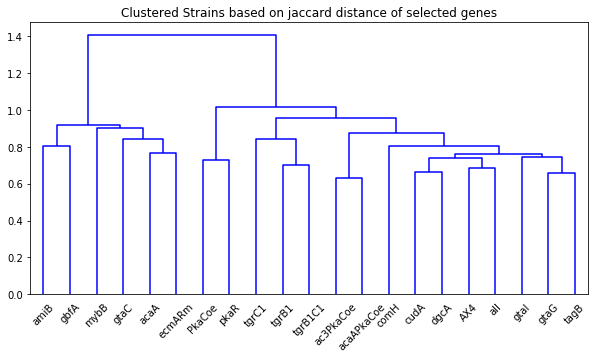

In [30]:
retained_genes(sims_dict2,nhubs=1000,splitby='Strain')

## Conclusion
Based on these results selection of genes/gene pairs based on 'all' vector may not be apropriate. To reduce the chance of having strong connections in AX4 and no similarity within developmentally stunted strains a very high similarity threshold would need to be used. This could filter out genes that have somewhat lower similarity which is nevertheless consistent across strains. 